In [ ]:
!pip install torch torchvision deeplake matplotlib

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color, exposure, restoration
from cv2.ximgproc import guidedFilter
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import deeplake
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score
import torch
import deeplake
import time
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import random

In [5]:
microscope_img = cv2.imread('microscope.jpg', cv2.IMREAD_GRAYSCALE)

In [6]:
print(microscope_img)

[[163 160 158 ... 213 212 211]
 [163 160 158 ... 213 213 212]
 [161 160 158 ... 213 213 213]
 ...
 [145 144 142 ... 255 255 255]
 [146 144 143 ... 255 255 255]
 [147 146 144 ... 255 255 255]]


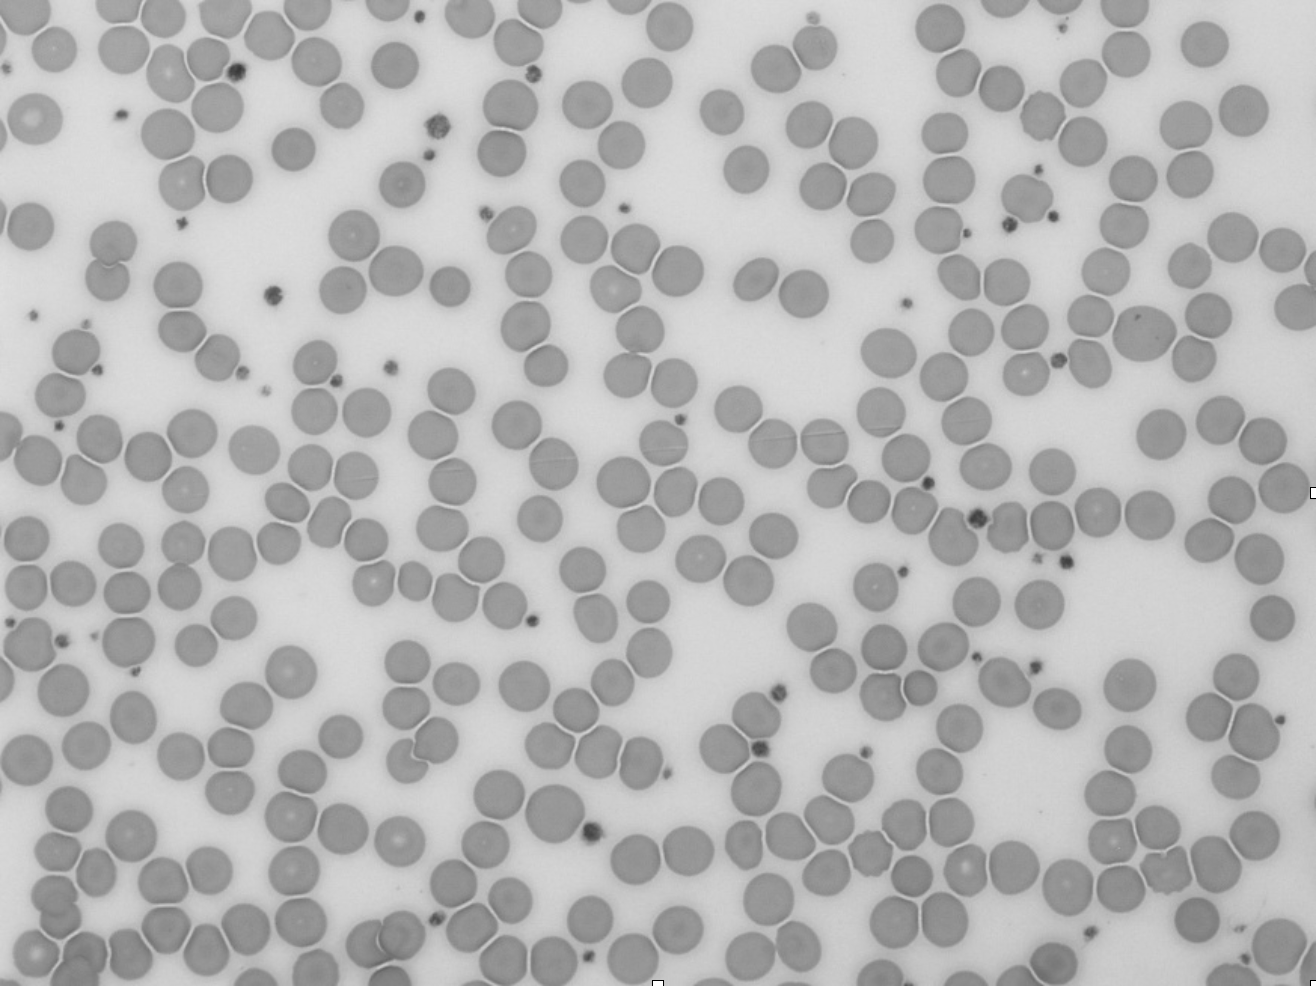

In [7]:
from google.colab.patches import cv2_imshow
cv2_imshow(microscope_img)

In [8]:
def LoG_blob_detection(image):
    log = cv2.Laplacian(image, cv2.CV_64F)
    return np.uint8(np.abs(log))

In [9]:
def DoG_blob_detection(image):
    gaussian1 = cv2.GaussianBlur(image, (5,5), 1)
    gaussian2 = cv2.GaussianBlur(image, (5,5), 2)
    dog = gaussian1 - gaussian2
    return np.uint8(np.abs(dog))

In [10]:
def HoG_blob_detection(image):
    from skimage.feature import hog
    fd, hog_image = hog(image, visualize=True)
    return hog_image

In [11]:
log_result = LoG_blob_detection(microscope_img)
dog_result = DoG_blob_detection(microscope_img)
hog_result = HoG_blob_detection(microscope_img)

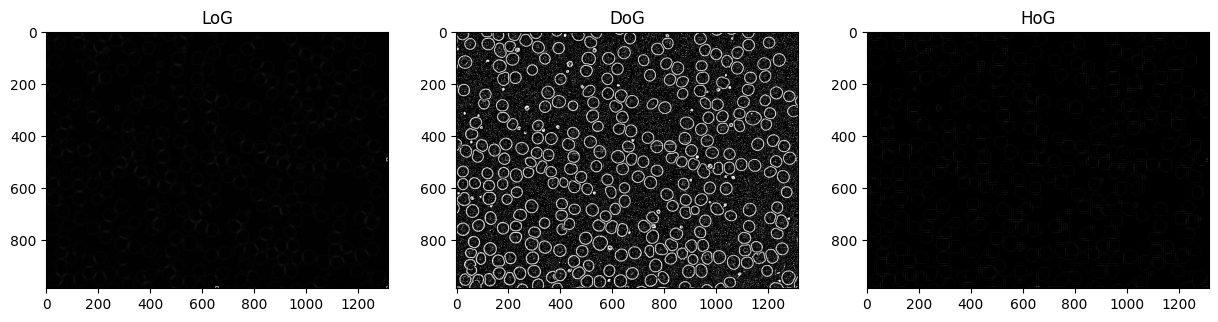

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(log_result, cmap='gray'); ax[0].set_title('LoG')
ax[1].imshow(dog_result, cmap='gray'); ax[1].set_title('DoG')
ax[2].imshow(hog_result, cmap='gray'); ax[2].set_title('HoG')
plt.show()

In [17]:
import deeplake
import torch
import torchvision.transforms as transforms

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169M/169M [00:14<00:00, 11.7MB/s]


In [23]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
resnet18 = models.resnet18(pretrained=True)
resnet34 = models.resnet34(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [26]:
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

In [27]:
resnet18 = resnet18.to(device)
resnet34 = resnet34.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()

optimizer18 = optim.Adam(resnet18.parameters(), lr=0.001)
optimizer34 = optim.Adam(resnet34.parameters(), lr=0.001)

In [29]:
def train_model(model, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [30]:
print("Training ResNet-18...")
start_time = time.time()
train_model(resnet18, optimizer18, train_loader, num_epochs=10)
resnet18_accuracy = evaluate_model(resnet18, test_loader)
resnet18_time = time.time() - start_time
print(f"ResNet-18 Test Accuracy: {resnet18_accuracy * 100:.2f}%")
print(f"ResNet-18 Inference Time: {resnet18_time:.2f} seconds")

Training ResNet-18...
Epoch 1, Loss: 2.935732127150611
Epoch 2, Loss: 2.138224547628856
Epoch 3, Loss: 1.7907289906078592
Epoch 4, Loss: 1.5362100111858925
Epoch 5, Loss: 1.2933528302880504
Epoch 6, Loss: 1.13367055303148
Epoch 7, Loss: 0.9224175127113566
Epoch 8, Loss: 0.7609618122467909
Epoch 9, Loss: 0.6884686328718425
Epoch 10, Loss: 0.5389417671143552
ResNet-18 Test Accuracy: 50.92%
ResNet-18 Inference Time: 314.53 seconds


In [31]:
print("\nTraining ResNet-34...")
start_time = time.time()
train_model(resnet34, optimizer34, train_loader, num_epochs=10)
resnet34_accuracy = evaluate_model(resnet34, test_loader)
resnet34_time = time.time() - start_time
print(f"ResNet-34 Test Accuracy: {resnet34_accuracy * 100:.2f}%")
print(f"ResNet-34 Inference Time: {resnet34_time:.2f} seconds")


Training ResNet-34...
Epoch 1, Loss: 3.1727619232119197
Epoch 2, Loss: 2.5118880852713916
Epoch 3, Loss: 2.3216979378629525
Epoch 4, Loss: 1.9149583149748994
Epoch 5, Loss: 1.6193076981912793
Epoch 6, Loss: 1.4881592820519987
Epoch 7, Loss: 1.3060602161585522
Epoch 8, Loss: 1.1188777925260842
Epoch 9, Loss: 0.8269529689455886
Epoch 10, Loss: 0.6352855277335857
ResNet-34 Test Accuracy: 51.01%
ResNet-34 Inference Time: 401.53 seconds


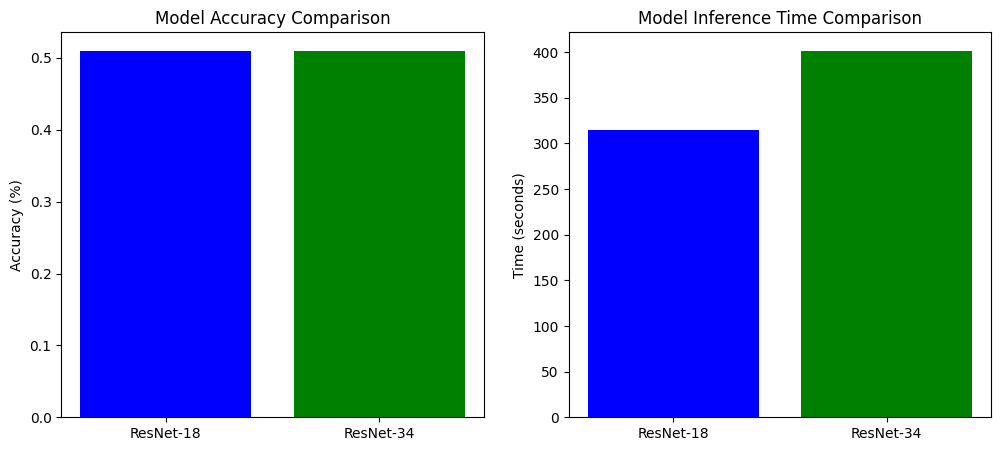

In [32]:
def plot_comparison(resnet18_acc, resnet34_acc, resnet18_time, resnet34_time):
    models = ['ResNet-18', 'ResNet-34']
    accuracies = [resnet18_acc, resnet34_acc]
    times = [resnet18_time, resnet34_time]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Comparison
    ax[0].bar(models, accuracies, color=['blue', 'green'])
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].set_ylabel('Accuracy (%)')

    # Inference Time Comparison
    ax[1].bar(models, times, color=['blue', 'green'])
    ax[1].set_title('Model Inference Time Comparison')
    ax[1].set_ylabel('Time (seconds)')

    plt.show()

plot_comparison(resnet18_accuracy, resnet34_accuracy, resnet18_time, resnet34_time)